In [8]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

%matplotlib inline

In [10]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

a_train = np.array(Dataset_loader('r"C:/Users\User/Desktop/FER_Bitirme/TRAIN_FILES/data-set/angry"',224))
d_train = np.array(Dataset_loader('C:/Users\User/Desktop/FER_Bitirme/TRAIN_FILES/data-set/disgust',224))
f_train = np.array(Dataset_loader('C:/Users\User/Desktop/FER_Bitirme/TRAIN_FILES/data-set/fear',224))
h_train = np.array(Dataset_loader('C:/Users/User/Desktop/FER_Bitirme/TRAIN_FILES/data-set/happy',224))
n_train = np.array(Dataset_loader('C:/Users/User/Desktop/FER_Bitirme/TRAIN_FILES/data-set/neutral',224))
sad_train = np.array(Dataset_loader('C:/Users/User/Desktop/FER_Bitirme/TRAIN_FILES/data-set/sad',224))
sur_train = np.array(Dataset_loader('C:/Users/User/Desktop/FER_Bitirme/TRAIN_FILES/data-set/surprise',224))


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 10-11: truncated \UXXXXXXXX escape (<ipython-input-10-6a0d302eaf15>, line 16)

In [3]:
a_train.shape

NameError: name 'a_train' is not defined

In [8]:
# Create labels

a_train_label = np.zeros(len(a_train))
d_train_label = np.ones(len(d_train))
f_train_label = np.full(len(f_train),2)
h_train_label = np.full(len(h_train),3)
n_train_label = np.full(len(n_train),4)
sad_train_label = np.full(len(sad_train),5)
sur_train_label = np.full(len(sur_train),6)


# Merge data 
X_train = np.concatenate((a_train, d_train,f_train,h_train,n_train,sad_train,sur_train), axis = 0)
Y_train = np.concatenate((a_train_label, d_train_label,f_train_label,h_train_label,n_train_label,sad_train_label,sur_train_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
    
)

In [13]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

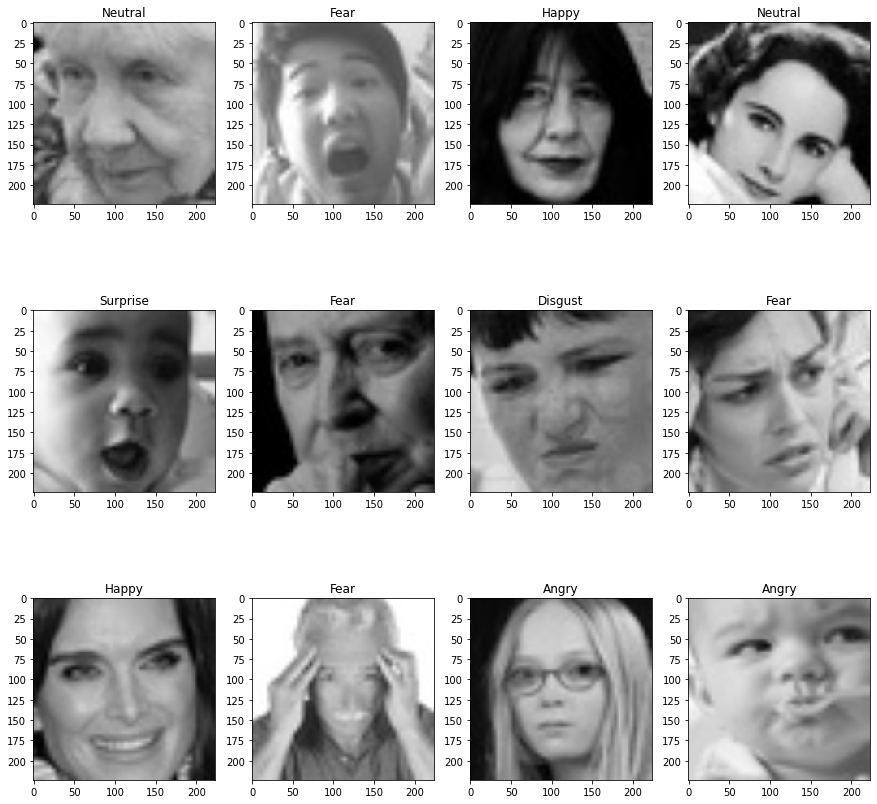

In [15]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Angry')
    if np.argmax(y_train[i]) == 1:
        ax.title.set_text('Disgust')
    if np.argmax(y_train[i]) == 2:
        ax.title.set_text('Fear')
    if np.argmax(y_train[i]) == 3:
        ax.title.set_text('Happy')
    if np.argmax(y_train[i]) == 4:
        ax.title.set_text('Neutral')
    if np.argmax(y_train[i]) == 5:
      ax.title.set_text('Sad')
    if np.argmax(y_train[i]) ==6:
        ax.title.set_text('Surprise')     
  
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [16]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [17]:

def build_model(backbone, lr=1e-4):
    model = Sequential()
    backbone.summary()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(7, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

In [18]:

K.clear_session()
gc.collect()
resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))
#efficeient.summary()
model = build_model(resnet ,lr = 1e-4)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [19]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
# Checkpoint
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [20]:
x_train.shape[0]/BATCH_SIZE

70.0

In [21]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
70/70 [==============================] - 57s 274ms/step - loss: 2.7400 - accuracy: 0.1068 - val_loss: 2.2684 - val_accuracy: 0.2000

Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to weights.hdf5
Epoch 2/100
70/70 [==============================] - 18s 249ms/step - loss: 2.5484 - accuracy: 0.1819 - val_loss: 2.4725 - val_accuracy: 0.2429

Epoch 00002: val_accuracy improved from 0.20000 to 0.24286, saving model to weights.hdf5
Epoch 3/100
70/70 [==============================] - 18s 250ms/step - loss: 2.5384 - accuracy: 0.1597 - val_loss: 2.1136 - val_accuracy: 0.2143

Epoch 00003: val_accuracy did not improve from 0.24286
Epoch 4/100
70/70 [==============================] - 17s 245ms/step - loss: 2.5182 - accuracy: 0.1706 - val_loss: 2.2826 - val_accuracy: 0.1250

Epoch 00004: val_accuracy did not improve from 0.24286
Epoch 5/100
70/70 [==============================] - 18s 254ms/step - loss: 2.4776 - accuracy: 0.1827 - val_loss: 2.0693 - val_accuracy

In [22]:
model.save('video.h5')

In [23]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

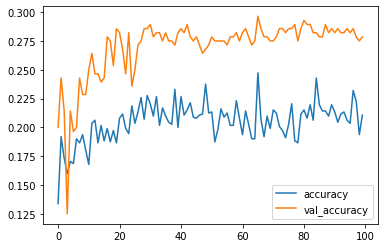

In [27]:

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

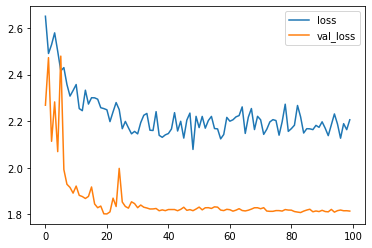

In [28]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

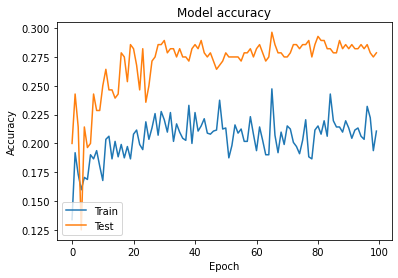

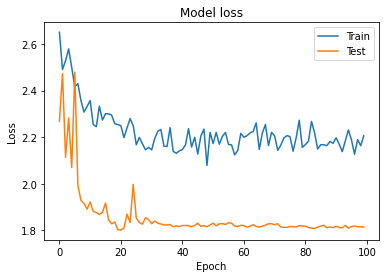

In [29]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

#Prediction

In [30]:
model.load_weights("weights.hdf5")

In [31]:
Y_test_pred = model.predict(x_test)

In [32]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))

0.29642857142857143

In [33]:
cohen_kappa_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))

0.1821484172288531

In [34]:
from sklearn.metrics import roc_auc_score

In [35]:
roc_auc_score(y_test,Y_test_pred)

0.6771333438951633

In [36]:
from sklearn.metrics import f1_score

In [37]:
f1_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1), average='macro')

0.26765422810415773

In [38]:
f1_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1), average='micro')

0.29642857142857143

In [39]:
 f1_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1), average='weighted')

0.26336030539185634

In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [41]:
precision_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1), average='macro')

0.2818196111346796

In [42]:
precision_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1), average='micro') 

0.29642857142857143

In [43]:
precision_score(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1), average='weighted')

0.2805506259341876

In [44]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 1s 86ms/step - loss: 1.8148 - accuracy: 0.2964


[1.8147904872894287, 0.2964285612106323]

In [45]:
Y_pred = model.predict(x_test)

#Confusion Matrix

Confusion matrix, without normalization
[[21  0  2  5  2  3  3]
 [14  8  2  6  2 10  1]
 [12  2  4  1  2  7 10]
 [ 2  6  1  8  5  7 12]
 [ 7  8  2  4  6  1 15]
 [11  9  4  0  3  8  6]
 [ 6  0  0  2  2  0 28]]


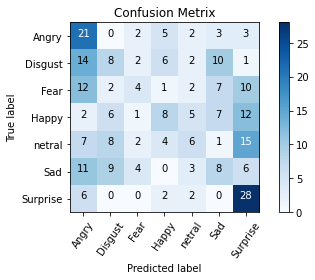

In [46]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))

cm_plot_label =['Angry', 'Disgust','Fear','Happy','netral','Sad','Surprise']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix')

Confusion matrix, without normalization
[[21  0  2  5  2  3  3]
 [14  8  2  6  2 10  1]
 [12  2  4  1  2  7 10]
 [ 2  6  1  8  5  7 12]
 [ 7  8  2  4  6  1 15]
 [11  9  4  0  3  8  6]
 [ 6  0  0  2  2  0 28]]


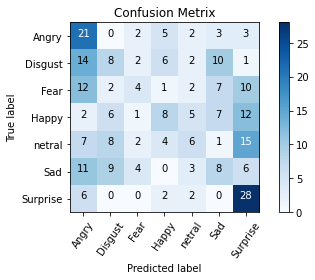

In [47]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))

cm_plot_label =['Angry', 'Disgust','Fear','Happy','netral','Sad','Surprise']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix')

In [48]:
from sklearn.metrics import classification_report
classification_report( np.argmax(y_test, axis=1), np.argmax(Y_test_pred, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.29      0.58      0.39        36\n           1       0.24      0.19      0.21        43\n           2       0.27      0.11      0.15        38\n           3       0.31      0.20      0.24        41\n           4       0.27      0.14      0.18        43\n           5       0.22      0.20      0.21        41\n           6       0.37      0.74      0.50        38\n\n    accuracy                           0.30       280\n   macro avg       0.28      0.31      0.27       280\nweighted avg       0.28      0.30      0.26       280\n'

In [49]:
y_score = model.predict(x_test)

In [50]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: ignored

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(Y_test_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break
i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(Y_test_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Angry"
    if namecode==1:
        return "Disgust"
    if namecode==2:
        return "Feat"
    if namecode==3:
        return "Happy"
    if namecode==4:
        return "Neutral"
    if namecode==5:
        return "Sad"
    if namecode==6:
        return "Surprise"                       
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_test_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(x_test[prop_class[i]], interpolation='nearest')
plt.show()